In [1]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from scipy.special import softmax
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

In [2]:
class OCRDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [3]:
test = torch.load('tok_test_dataset')

In [4]:
results = torch.load('results.pt')

In [5]:
# all_ids = test[0]
# all_labels = results.label_ids
# predictions = results.predictions

In [6]:
# for i in range(200000):
#     hid = all_ids[i]
#     labels = all_labels[i]
#     real_labels = labels != -100
#     labels = labels[real_labels]
#     prediction = predictions[i].argmax(-1)[real_labels]

In [7]:
all_labels = results.label_ids
predictions = results.predictions
real_labels = all_labels != -100
labels = all_labels[real_labels]
preds = predictions[real_labels]

In [8]:
preda = softmax(preds,axis=1)

In [9]:
def compute_metrics(labels, preds):
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [10]:
print(compute_metrics(labels, preda.argmax(-1)))

{'accuracy': 0.977300241681586, 'f1': 0.6888148494755078, 'precision': 0.8465275507260314, 'recall': 0.5806386930642914}


In [11]:
fpr, tpr, roc_threshold = metrics.roc_curve(labels, preda[:,1])
roc_auc = metrics.auc(fpr, tpr)

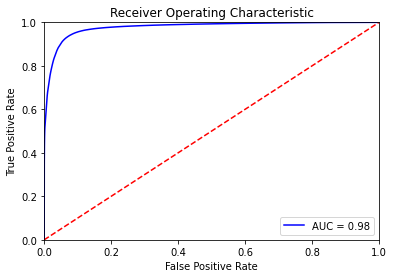

In [12]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [13]:
prec, recall, pr_threshold = metrics.precision_recall_curve(labels, preda[:,1])
avg_prec = metrics.average_precision_score(labels, preda[:,1])

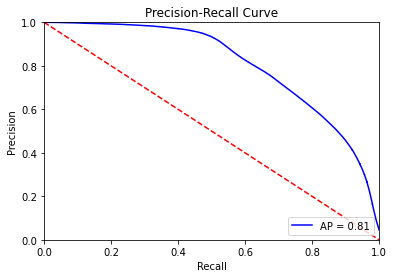

In [14]:
plt.title('Precision-Recall Curve')
plt.plot(recall, prec, 'b', label = 'AP = %0.2f' % avg_prec)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [15]:
thres_idx = np.argmin(np.abs(recall-prec))
thres = pr_threshold[thres_idx]
print("Threshold:", thres)
pos_idx = np.where(preda[:,1] > thres)[0]
preds = np.zeros(len(preda))
preds[pos_idx] = 1
print(compute_metrics(labels, preds))

Threshold: 0.3266818
{'accuracy': 0.9750996390016157, 'f1': 0.7122549291203965, 'precision': 0.7122568083119186, 'recall': 0.7122530499387901}


In [16]:
result_paths = Path('/home/allekim/stonybook-dev/hathi_similarity/new_ocr_detection/stored_test_results/').glob('*')

In [17]:
def compute_confusion(pred, labels):
    real_labels = labels != -100
    labels = labels[real_labels]
    preds = pred.argmax(-1)[real_labels]
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp
    }

In [19]:
book_stats = []
for p in tqdm(result_paths):
    result = torch.load(p)
    book_stats.append(compute_confusion(result.predictions, result.label_ids))

2796it [02:13, 20.89it/s]


In [20]:
df = pd.DataFrame(book_stats)

In [21]:
df

,tn,fp,fn,tp
0,19018,234,458,912
1,20706,143,464,405
2,6330,90,163,392
3,7819,116,92,314
4,1713,5,6,40
...,...,...,...,...
2791,7878,92,233,345
2792,7060,46,207,347
2793,1813,10,47,44
2794,43825,416,2271,1659


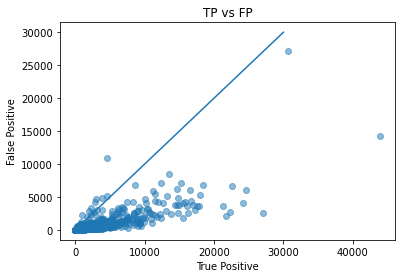

In [25]:
plt.scatter(df['tp'], df['fp'], alpha=0.5)
plt.plot([0,30000], [0,30000])
plt.title('TP vs FP')
plt.xlabel('True Positive')
plt.ylabel('False Positive')
plt.show()